# ETL with tf & Keras

## Librairies

In [1]:
import os
import math

import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.__version__

'2.4.1'

## Paths & Config

In [2]:
DATA_DIR = "/home/joseph/idermatoDeepLearning/data/raw_Data/images_medicales"
CHECKPOINT = "models/classifier-weights.hdf5"
SAVE_MODEL_PATH = "models/classifier.h5"
TENSORBOARD = "logs"

VALIDATION_SPLIT = 0.2

WIDTH = 150
HEIGHT = 150
NUM_CHANNELS = 3
INPUT_SHAPE = (WIDTH, HEIGHT, NUM_CHANNELS)

LEARNING_RATE = 1e-4

EPOCHS = 10
BATCH_SIZE = 16

## Data

In [3]:
# listing all images paths
images = glob.glob(DATA_DIR+'/*/*.*')
np.random.shuffle(images)
n_samples = len(images)
print("Total images:", n_samples)

Total images: 736


In [4]:
# associate label to each image
labels = [path.split('/')[-2] for path in images]
len(labels)

736

### Encode label into one hot

In [5]:
# encode labels into numeric values
label_encoder = LabelEncoder()
label_encoder.fit(labels)
labels = label_encoder.transform(labels).reshape(-1, 1)

# encode labels into onehot array
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(labels)
labels = one_hot_encoder.transform(labels).toarray()
labels.shape

(736, 10)

In [6]:
num_classes = len(label_encoder.classes_)
print("Total classes:", num_classes)

Total classes: 10


### Split train, val

In [7]:
train_images, val_images, train_labels, val_labels = train_test_split(images,
                                                                      labels,
                                                                      test_size=VALIDATION_SPLIT,
                                                                      stratify=labels)

### Build Data Generator

In [8]:
def load_image(path, size):
    """custom function to load image"""
    image = Image.open(path)
    image = image.convert('RGB')
    image = image.resize(size)
    image = np.array(image)*(1./255)

    return image

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    """Custom generator"""
    def __init__(self, x_set, y_set, batch_size=32, target_size=(150, 150)):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array([
            load_image(file_name, (WIDTH, HEIGHT))
               for file_name in batch_x]), np.array(batch_y)

In [10]:
train_ds = DataGenerator(train_images, train_labels, batch_size=BATCH_SIZE)
val_ds = DataGenerator(val_images, val_labels, batch_size=BATCH_SIZE)

## Model Transfer Learning

In [11]:
def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.inception_v3.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape)

    # Freeze base model
    base_model.trainable = False

    # Build model
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(name='globalaverage2d1'),
        tf.keras.layers.Dense(1024, activation='relu', name='dense1024'),
        tf.keras.layers.Dense(units=num_classes, activation='softmax', name='classifier')
    ])

    return model

model = build_model(INPUT_SHAPE, num_classes)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
globalaverage2d1 (GlobalAver (None, 2048)              0         
_________________________________________________________________
dense1024 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
classifier (Dense)           (None, 10)                10250     
Total params: 23,911,210
Trainable params: 2,108,426
Non-trainable params: 21,802,784
_________________________________________________________________
None


## Restore checkpoints

In [12]:
if os.path.exists(CHECKPOINT):
    try:
        _ = model.load_weights(CHECKPOINT, by_name=False)
    except:
        pass

## Loss & Optimizer

In [13]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(lr=LEARNING_RATE),
              metrics=["acc"])

## Callbacks

In [14]:
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT,
    verbose=0,
    save_weights_only=True
)
callback_tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=TENSORBOARD,
    write_images=True
)

callbacks = [callback_checkpoint, callback_tensorboard]

## Training

In [15]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10
26/37 [====================>.........] - ETA: 1:16 - loss: 0.4135 - acc: 0.8936

/home/joseph/anaconda3/envs/tf/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


37/37 [==============================] - 387s 9s/step - loss: 0.3988 - acc: 0.8985 - val_loss: 0.2698 - val_acc: 0.9189
Epoch 2/10
37/37 [==============================] - 312s 8s/step - loss: 0.1128 - acc: 0.9650 - val_loss: 0.5343 - val_acc: 0.8243
Epoch 3/10
37/37 [==============================] - 311s 8s/step - loss: 0.0874 - acc: 0.9858 - val_loss: 0.3039 - val_acc: 0.9054
Epoch 4/10
37/37 [==============================] - 313s 8s/step - loss: 0.0777 - acc: 0.9782 - val_loss: 0.2301 - val_acc: 0.9257
Epoch 5/10
37/37 [==============================] - 315s 9s/step - loss: 0.0313 - acc: 0.9960 - val_loss: 0.4549 - val_acc: 0.8649
Epoch 6/10
37/37 [==============================] - 310s 8s/step - loss: 0.0781 - acc: 0.9764 - val_loss: 0.3929 - val_acc: 0.8716
Epoch 7/10
37/37 [==============================] - 312s 8s/step - loss: 0.0479 - acc: 0.9875 - val_loss: 0.2775 - val_acc: 0.9189
Epoch 8/10
37/37 [==============================] - 314s 8s/step - loss: 0.0355 - acc: 0.9926 

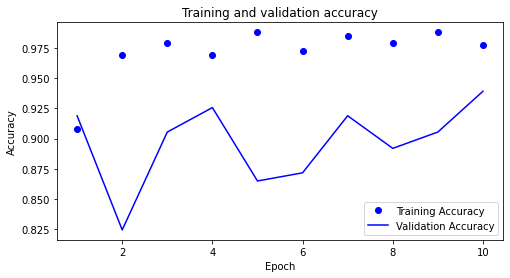

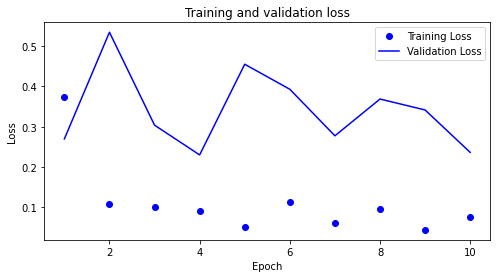

In [16]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.show()

## Save model

In [17]:
model.save(SAVE_MODEL_PATH)